In [14]:
import numpy as np   
import pandas as pd   
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.inspection import PartialDependenceDisplay

import pickle

# 1. Analyse the data

In [2]:
#ensure reproducibility
np.random.seed(123) 

#not disable warnings
import warnings  
warnings.filterwarnings("ignore")

#import data
data = pd.read_csv('Adult Income Dataset.csv')

In [3]:
# Displaying first five rows of the dataset
print(data.head())

print(data.info())

print(data['income'].value_counts())

   age      workclass     education marital_status    occupation   race  \
0   28        Private     Bachelors         Single  White-Collar  White   
1   30  Self-Employed         Assoc        Married  Professional  White   
2   32        Private  Some-college        Married  White-Collar  White   
3   20        Private  Some-college         Single       Service  White   
4   41  Self-Employed  Some-college        Married  White-Collar  White   

   gender  hours_per_week  income  
0  Female              60       0  
1    Male              65       1  
2    Male              50       0  
3  Female              35       0  
4    Male              50       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   education       26048 non-null  object
 3   

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

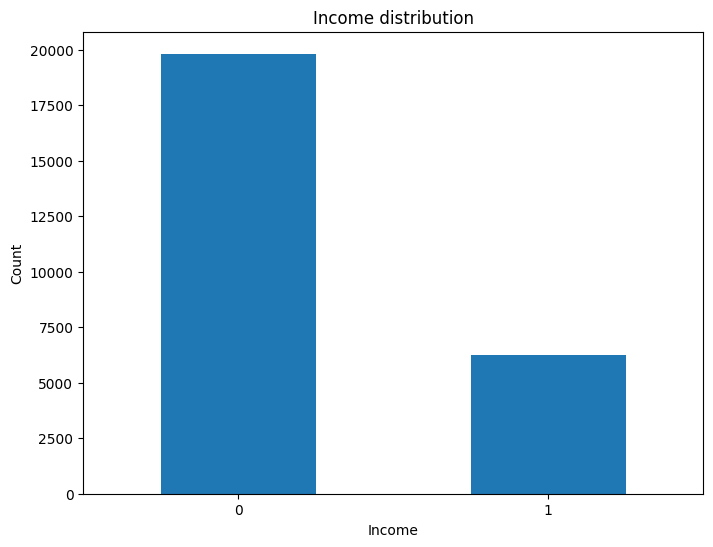

In [4]:
# Plot the income distribution
plt.figure(figsize=(8,6))
data['income'].value_counts().plot(kind='bar')
plt.title('Income distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 2. Preprocessing the data

In [5]:
# Creating the target and the features column and splitting the dataset into test and validation set.  
X = data.iloc[:, :-1]  
y = data.iloc[:, -1]  
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_valid.shape)

(19536, 8) (6512, 8)


In [6]:
# identifying numerical and categorical columns in the dataset
numerical_features = ["age", "hours_per_week"]
categorical_features = X_train.columns.drop(numerical_features)
print(categorical_features)
print(numerical_features)

Index(['workclass', 'education', 'marital_status', 'occupation', 'race',
       'gender'],
      dtype='object')
['age', 'hours_per_week']


In [7]:
#create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
)


# 3. Building the model

In [8]:
#Building the model
model = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
)


In [9]:
# Training the model
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['workclass', 'education', 'marital_status', 'occupation', 'race',
       'gender'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  ['age', 'hours_per_week'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])

# 4. Evaluation of the model

In [11]:
# Evaluating the model
y_pred_proba = model.predict_proba(X_valid)[:, 1]

AUC Score: 0.8604872477379488


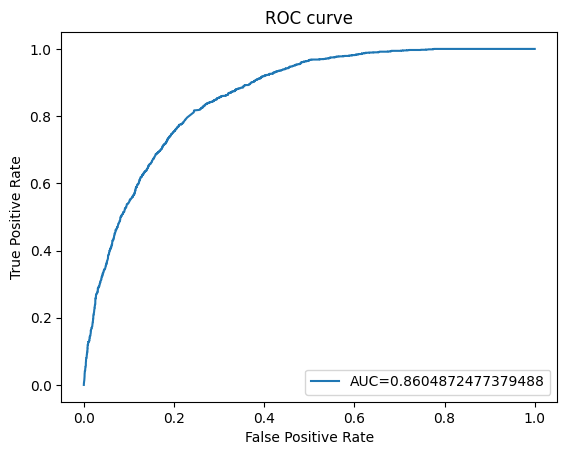

In [12]:
# Computing AUC score
auc_score = roc_auc_score(y_valid, y_pred_proba)
print(f"AUC Score: {auc_score}")

fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label="AUC="+str(auc_score))
plt.title("ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

In [13]:
#saving the model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 5. Interpretation of the model 

In [16]:
# Load the saved Random Forest model
with open('model.pkl', 'rb') as f:
    clf = pickle.load(f)
print(clf)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['workclass', 'education', 'marital_status', 'occupation', 'race',
       'gender'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  ['age', 'hours_per_week'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])


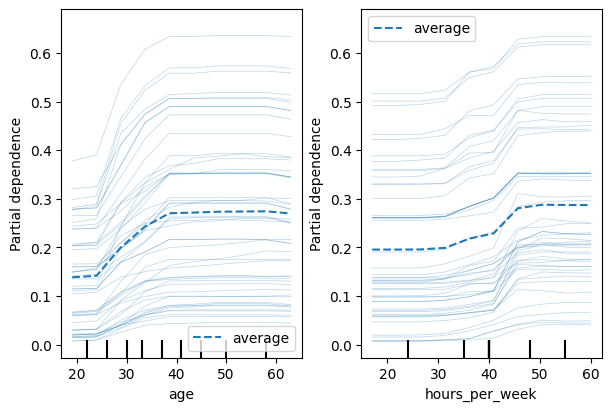

In [17]:
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(6,4), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    clf,
    X_train,
    features = ["age","hours_per_week"],
    kind = "both",
    subsample = 50,
    grid_resolution = 10,
    random_state = 0,
    ax=ax,
    
)